# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [ ]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [ ]:
# Download the dataset
#!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
# datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
# datafile.extractall()
# datafile.close()

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

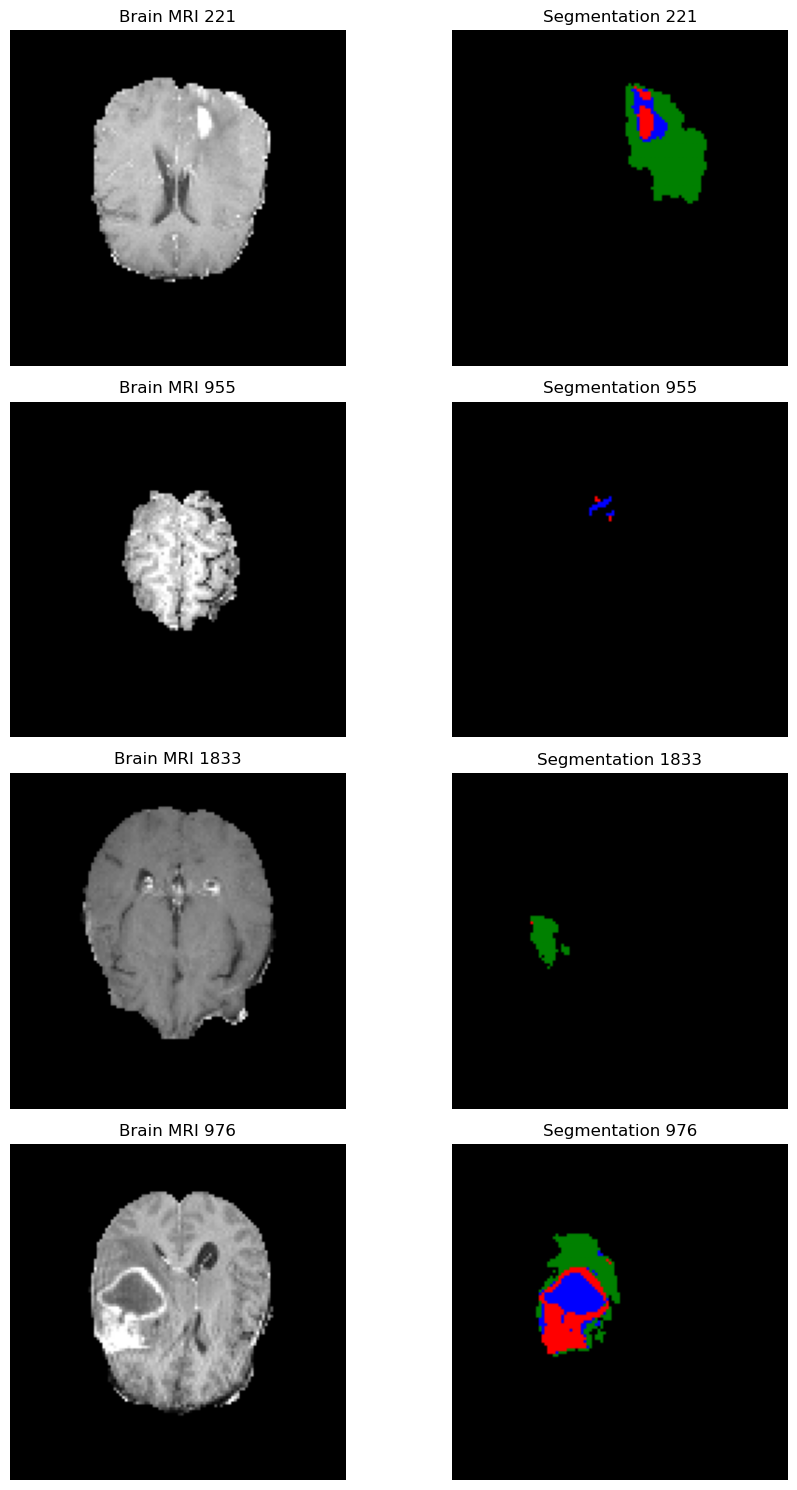

In [ ]:
### Insert your code ###
# Define paths
train_image_dir = "Task01_BrainTumour_2D/training_images"
train_label_dir = "Task01_BrainTumour_2D/training_labels"

# Get all image filenames
image_filenames = sorted(os.listdir(train_image_dir))
label_filenames = sorted(os.listdir(train_label_dir))

# Define a colormap for segmentation masks
cmap_labels = colors.ListedColormap(["black", "green", "blue", "red"])

# Select 4 random images
random_indices = random.sample(range(len(image_filenames)), 4)

# Create a figure to show the MRI and the Segmentation
fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for i, idx in enumerate(random_indices):
    img_path = os.path.join(train_image_dir, image_filenames[idx])
    label_path = os.path.join(train_label_dir, label_filenames[idx])

    image = imageio.imread(img_path)
    label = imageio.imread(label_path)

    axes[i, 0].imshow(image, cmap="gray")
    axes[i, 0].set_title(f"Brain MRI {idx}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(label, cmap=cmap_labels)
    axes[i, 1].set_title(f"Segmentation {idx}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [ ]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        # Get a random sample of the images based on the batch size
        indices = random.sample(range(len(self.images)), batch_size)
        for idx in indices:
            image = normalise_intensity(self.images[idx])
            label = self.labels[idx]

            # Add extra dimension for channel (required by PyTorch: (C, H, W))
            image = np.expand_dims(image, axis=0)
            images.append(image)
            labels.append(label)

        ### End of your code ###
        return np.array(images), np.array(labels)

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [ ]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path
        ### Insert your code ###
        n /= 2  # 64
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(int(n * 2), int(n), kernel_size=2, stride=2),
            nn.BatchNorm2d(int(n)),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(int(n * 2), int(n), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n)),
            nn.ReLU(),
            nn.Conv2d(int(n), int(n), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n)),
            nn.ReLU()
        )

        n /= 2  # 32
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(int(n * 2), int(n), kernel_size=2, stride=2),
            nn.BatchNorm2d(int(n)),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(int(n * 2), int(n), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n)),
            nn.ReLU(),
            nn.Conv2d(int(n), int(n), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n)),
            nn.ReLU()
        )

        n /= 2  # 16
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(int(n * 2), int(n), kernel_size=2, stride=2),
            nn.BatchNorm2d(int(n)),
            nn.ReLU()
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(int(n * 2), int(n), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n)),
            nn.ReLU(),
            nn.Conv2d(int(n), int(n), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n)),
            nn.ReLU()
        )

        self.final_conv = nn.Conv2d(int(n), output_channel, kernel_size=1)

        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        x = self.deconv4(x)
        x = torch.cat((x, conv3_skip), dim=1)
        x = self.conv5(x)

        x = self.deconv3(x)
        x = torch.cat((x, conv2_skip), dim=1)
        x = self.conv6(x)

        x = self.deconv2(x)
        x = torch.cat((x, conv1_skip), dim=1)
        x = self.conv7(x)

        x = self.final_conv(x)
        return x

## 4. Train the segmentation model.

In [ ]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 1000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    # Zero gradients
    optimizer.zero_grad()

    # Compute loss
    loss = criterion(logits, labels)

    # Backpropagate
    loss.backward()
    optimizer.step()

    if it % 100 == 0:
        print(f"Iteration {it}, Loss: {loss.item():.4f}")
    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss

            ### Insert your code ###

            # Get a batch of test images and labels
            images, labels = test_set.get_random_batch(eval_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

            # Forward pass
            logits = model(images)

            # Compute test loss
            test_loss = criterion(logits, labels)
            print(f"Test Loss: {test_loss.item():.4f}")

            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cpu
Iteration 100, Loss: 0.2636
Test Loss: 0.2581
Iteration 200, Loss: 0.1248
Test Loss: 0.1494
Iteration 300, Loss: 0.1167
Test Loss: 0.1403
Iteration 400, Loss: 0.0746
Test Loss: 0.1000
Iteration 500, Loss: 0.0807
Test Loss: 0.1226
Iteration 600, Loss: 0.0565
Test Loss: 0.0523
Iteration 700, Loss: 0.0490
Test Loss: 0.0418
Iteration 800, Loss: 0.0683
Test Loss: 0.0651
Iteration 900, Loss: 0.0687
Test Loss: 0.0422
Iteration 1000, Loss: 0.0412
Test Loss: 0.0486
Training took 1579.396s in total.


## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

In [28]:
### Insert your code ###
# Load the best trained model (update the filename accordingly)
model.load_state_dict(torch.load('saved_models/model_10000.pt', weights_only=True))  # Change to latest checkpoint
model.to(device)
model.eval()  # Set to evaluation mode

# Load test dataset
test_image_dir = "Task01_BrainTumour_2D/test_images"
test_label_dir = "Task01_BrainTumour_2D/test_labels"

test_image_filenames = sorted(os.listdir(test_image_dir))
test_label_filenames = sorted(os.listdir(test_label_dir))

# Define loss function
criterion = nn.CrossEntropyLoss()

# Initialize evaluation metrics
total_loss = 0.0
correct_pixels = 0
total_pixels = 0

# Process all test images
for img_name, lbl_name in zip(test_image_filenames, test_label_filenames):
    img_path = os.path.join(test_image_dir, img_name)
    lbl_path = os.path.join(test_label_dir, lbl_name)

    # Read image and label
    image = imageio.imread(img_path)
    label = imageio.imread(lbl_path)

    # Normalize image
    input_image = normalise_intensity(image)
    input_tensor = torch.tensor(input_image).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)

    label_tensor = torch.tensor(label).unsqueeze(0).to(device, dtype=torch.long)

    with torch.no_grad():
        output = model(input_tensor)
        loss = criterion(output, label_tensor)

    # Compute loss
    total_loss += loss.item()

    # Compute accuracy
    prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Convert to numpy
    correct_pixels += np.sum(prediction == label)  # Count matching pixels
    total_pixels += label.size  # Total number of pixels

# Compute average loss and accuracy
average_test_loss = total_loss / len(test_image_filenames)
accuracy = correct_pixels / total_pixels * 100  # Convert to percentage

print(f"Test Loss: {average_test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")
### End of your code ###


Test Loss: 0.0514
Test Accuracy: 98.90%


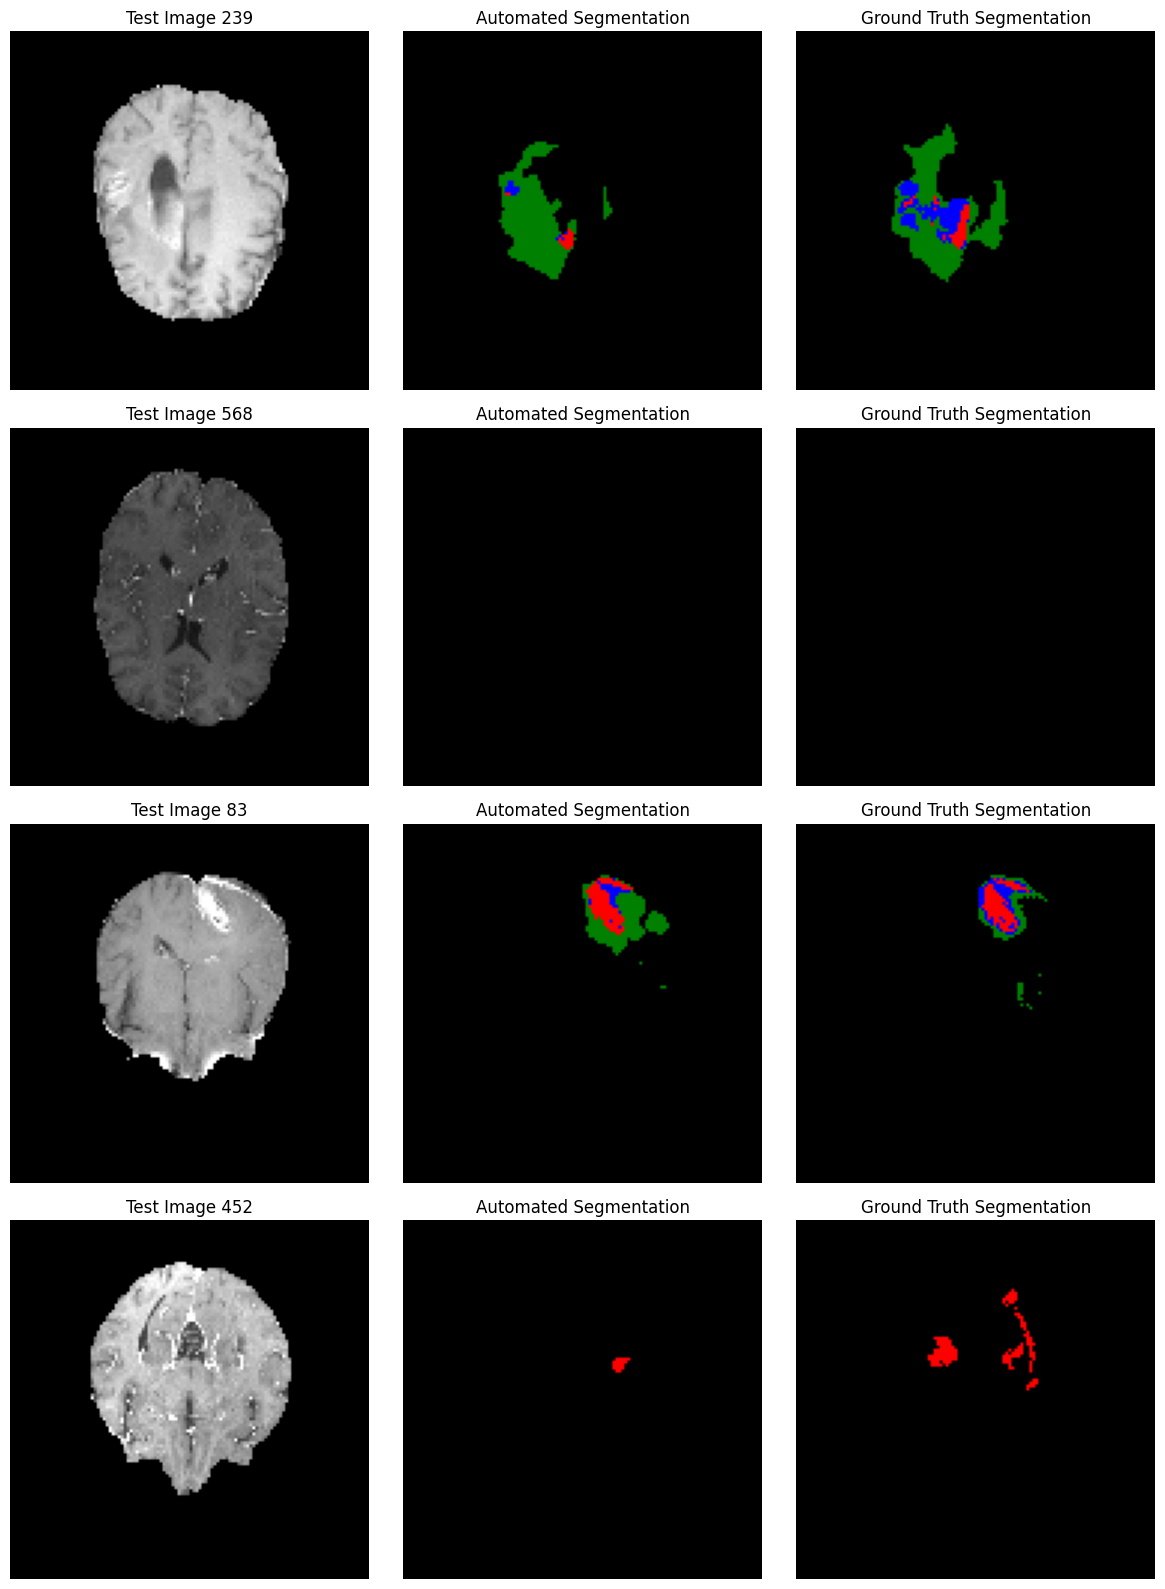

In [38]:
# Select 4 random indices
random_indices = random.sample(range(len(test_image_filenames)), 4)

fig, axes = plt.subplots(4, 3, figsize=(12, 16))

cmap_labels = colors.ListedColormap(['black', 'green', 'blue', 'red'])

for i, idx in enumerate(random_indices):
    img_path = os.path.join(test_image_dir, test_image_filenames[idx])
    label_path = os.path.join(test_label_dir, test_label_filenames[idx])

    # Read the image and label
    image = imageio.imread(img_path)
    label = imageio.imread(label_path)

    # Normalize and add batch/channel dimensions
    input_image = normalise_intensity(image)
    input_tensor = torch.tensor(input_image).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)  # Shape: (1,1,H,W)

    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Convert to numpy array

    # Plot test image
    axes[i, 0].imshow(image, cmap="gray")
    axes[i, 0].set_title(f"Test Image {idx}")
    axes[i, 0].axis("off")

    # Plot automated segmentation
    axes[i, 1].imshow(prediction, cmap=cmap_labels)
    axes[i, 1].set_title("Automated Segmentation")
    axes[i, 1].axis("off")

    # Plot ground truth segmentation
    axes[i, 2].imshow(label, cmap=cmap_labels)
    axes[i, 2].set_title("Ground Truth Segmentation")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

The trained U-Net model achieves a test loss of 0.0514 and an accuracy of 98.90%, indicating strong segmentation performance. From the visualized results, the automated segmentations closely match the ground truth for most images. The model successfully identifies tumor regions and distinguishes between different tissue types.

However, some misclassifications appear at tumor boundaries, where certain segmentations exhibit slight mismatches. This suggests that while the model performs well, it is not yet clinically reliable for real-world medical applications.

To improve clinical reliability, the model should be trained on a more diverse dataset. It may currently be optimised for a specific type of brain scan, limiting its generalisability. By incorporating MRI scans from multiple hospitals and different imaging protocols, the model can better handle variations in scanner types, patient demographics, and tumor characteristics.

While the model demonstrates high accuracy, it requires further improvements in generalization, robustness, and clinical validation before being deployed in a real-world medical setting.